# Segment Outline PNGs with Contour Masks and SAM2

In [17]:
import cv2
import json
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import colorsys
import torch
import random
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter
import pickle
import ast
from tqdm.notebook import tqdm
import re

# Set a specific seed for reproducibility
SEED = 42

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

# Set seed for other libraries if necessary
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.float16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
HOME = "/content/drive/MyDrive/Masterarbeit"
Path.home = lambda: Path(HOME)
print("HOME:", HOME)

HOME: /content/drive/MyDrive/Masterarbeit


In [5]:
os.chdir(f"{HOME}/segment-anything-2")
!pip install -e .

Obtaining file:///content/drive/MyDrive/Masterarbeit/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.0 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13883 sha256=8736bb9c693802f45323d13edbba808bf3235ffde82338e4519cc769e4a18321
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qfzgxxf/wheels/28/a6/7a/36058b361f8d206a57111d0811b888553be3f0702adc359306
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=c5d5039a3ef028bc9024d6c0ca9db947d95f7ef2ff453484f584f3c1c4fcd646
  Stored in dire

In [6]:
# @title
# !mkdir -p {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/segment-anything-2/checkpoints
# !wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/segment-anything-2/checkpoints

In [11]:
# Base data folder
data_folder = Path.home() / "data"

# Paths
IN_DIR   = data_folder / "outline_images"
OUT_DIR  = data_folder / "segmented_images"
CV_MASKS = data_folder / "cv_masks"
SAM_MASKS= data_folder / "sam_masks"

# Create needed directories
OUT_DIR.mkdir(parents=True, exist_ok=True)
CV_MASKS.mkdir(parents=True, exist_ok=True)
SAM_MASKS.mkdir(parents=True, exist_ok=True)

# Load CSV
df = pd.read_csv(data_folder / "final_images.csv")

# CV2 mask quality thresholds
MIN_FG = 0.055   # min acceptable foreground ratio (avoid empty masks)
MAX_FG = 0.98   # max acceptable foreground ratio (avoid filled squares)

# SAM2 model setup (edit if you have SAM2 locally)
# - model_cfg is one of the YAMLs in the SAM2 repo (e.g., sam2_hiera_s.yaml)
# - ckpt points to the checkpoint file you downloaded
SAM2_ENABLED = True   # set False to skip SAM2 even if available
model_cfg = "configs/sam2/sam2_hiera_l.yaml"   # e.g., "/path/to/sam2/configs/sam2_hiera_s.yaml"
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"        # e.g., "/path/to/ckpts/sam2_hiera_s.pth"
DEVICE = "cuda"       # "cuda" or "cpu" (cuda recommended for speed)


In [12]:
 df

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects
0,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1
1,"['black', 'white', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1
2,"['white', 'brown']",yellow,hare,https://t3.ftcdn.net/jpg/09/64/55/74/360_F_964...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1
...,...,...,...,...,...,...,...,...,...
384,"['green', 'brown']",purple,bottle,https://c8.alamy.com/comp/2N4GG52/vector-black...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1
385,['yellow'],green,cab,https://illustoon.com/photo/4847.png,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1
386,"['black', 'brown']",purple,buzzard,https://c8.alamy.com/comp/3BMJHY0/forest-anima...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1
387,['brown'],blue,French loaf,https://previews.123rf.com/images/rastudio/ras...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1


## SAM 2

In [9]:
# Try importing SAM2 if installed
SAM2_AVAILABLE = False
if SAM2_ENABLED:
    try:
        from sam2.build_sam import build_sam2
        from sam2.sam2_image_predictor import SAM2ImagePredictor
        SAM2_AVAILABLE = True
        sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
        predictor = SAM2ImagePredictor(sam2_model)
        print("SAM2 is available.")
    except Exception as e:
        print("SAM2 not available or failed to import:", e)
        SAM2_AVAILABLE = False

print("OpenCV version:", cv2.__version__)

SAM2 is available.
OpenCV version: 4.12.0


In [10]:
def show_points(coords, labels, ax, marker_size=375):
    """Sam2 function to show points."""
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """Sam2 function to show the box over the image."""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_mask(mask, ax, random_color=False, borders = True):
    """Visualize mask in the image"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    """Plot ALL images masks in a set"""
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [11]:
# This is for all colors EXCEPT for White.
def color_remap(pixel, current_color, target_color, alpha=0.2, saturation_threshold=0.1):
    """Remaps pixels from current_color to target_color within a hue range."""


    color_hue_map = {
        "red": 0.0,
        "brown": 0.05,
        "pink": 0.9,
        "orange": 0.07,
        "yellow": 0.15,
        "gold": 0.1,
        "green": 0.33,
        "blue": 0.55,
        "purple": 0.78,
        "black": 0.0,
        "grey": 0.0,
        "silver": 0.0,
        "white": 0.0,
    }

    current_hue = color_hue_map[current_color]
    target_hue = color_hue_map[target_color]

    r, g, b = pixel
    h, s, v = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)

    if current_color in ['black', 'grey', 'silver']:
        if v < 0.75 and s < 0.5:
            new_h = target_hue

            # Custom logic per target color
            if target_color == 'red':
                new_h = target_hue  # around 0.0
                new_s = max(0.4, min(1.0, s * 1.5 + 0.35))
                new_v = max(0.4, min(1.0, v * 2 + 0.25))

            elif target_color == 'brown':
                new_h = target_hue  # around 0.05 - 0.08
                new_s = max(0.7, min(0.9, s + 0.3))
                new_v = max(0.3, min(0.5, v + 0.2))  # darker

            elif target_color == 'pink':
                new_h = target_hue  # around 0.9 - 1.0
                # Lower the brightness boost so pinks are less light.
                new_v = max(0.80, min(1.0, v * 1.750 + 0.2))
                # Adjust saturation gently to keep a soft pink without over-saturating.
                new_s = max(0.4, min(0.7, s * 1.5 + 0.2))

            elif target_color == 'orange':
                new_h = target_hue

                # Boost saturation aggressively into the vivid region.
                # Using a multiplier and an offset to ensure a high saturation.
                new_s = max(0.90, min(1.0, s * 2.2 + 0.35))

                # Increase brightness to be vivid without overexposing,
                # ensuring the pixel leaves the 'black' territory.
                new_v = max(0.85, min(1.0, v * 2.2 + 0.35))

            elif target_color == 'yellow':
                new_h = target_hue  # around 0.13 - 0.17
                new_s = max(0.6, min(1.0, s * 1.6 + 0.2))
                new_v = max(0.7, min(1.0, v * 1.65 + 0.3))  # very bright

            elif target_color == 'green':
                new_h = target_hue  # around 0.25 - 0.4
                new_s = max(0.65, min(1.0, s * 1.8 + 0.3))
                new_v = max(0.55, min(1.0, v * 1.6 + 0.3))

            elif target_color == 'blue':
                new_h = target_hue  # around 0.55 - 0.65
                new_s = max(0.8, min(1.0, s * 2 + 0.4))
                new_v = max(0.7, min(1.0, v * 1.5 + 0.2))

            elif target_color == 'purple':
                new_h = target_hue  # around 0.75 - 0.85
                new_s = max(0.65, min(1.0, s * 1.6 + 0.25))
                new_v = max(0.55, min(1.0, v * 1.5 + 0.35))

            else:
                # Default fallback
                new_s = min((s + 0.3) * 1.5, 1)
                new_v = min((v + 0.3) * 1.5, 1)

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    elif current_color == 'brown':
        if (0.0 <= h <= 0.15 and 0.25 <= s <= 1 and 0 <= v <= 0.95):
            new_h = target_hue
            if v < 0.6 and s < 0.8:
                new_v = min((v+0.05)*1.1, 1)
                new_s = min((s+0.1)*1.1, 1)
            else:
                new_v = min(v, 1)
                new_s = min(s, 1)

            if target_color == 'grey':
                # This gives gray
                new_h = 0
                new_s = 0
                new_v = v*0.75

            if target_color == 'orange':
                new_v = min(v*1.75, 1)
                new_s = min(s*1.75, 1)

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    elif current_color == 'white':
        if s <= 0.1 and v >= 0.5:
            new_h = target_hue
            new_v = v*0.95
            new_s = min((s+0.2)*1.75, 1)

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    # ADD LOGIC FOR RED
    elif current_color == 'red':
        if ((h < 0.1 or h > 0.9) and s >= 0.2 and v >= 0.2):
            new_h = target_hue
            new_v = v
            new_s = s*0.95

            if target_color == 'black':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(h, 0, v*0.35)
                return int(r * 255), int(g * 255), int(b * 255)

            if target_color == 'grey':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(0, 0, v*0.75)
                return int(r * 255), int(g * 255), int(b * 255)

            if target_color == 'brown':
                new_h = target_hue
                new_v = v*0.65
                new_s = s*0.85
                r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
                return int(r * 255), int(g * 255), int(b * 255)


            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    if current_color == "pink":
        # This condition now covers pink and slightly orange-leaning pixels.
        if ((h <= 0.16 or h >= 0.85) and 0.05 <= s <= 0.9 and v >= 0.6):
            new_h = target_hue  # remap the hue to your target color

            # If the hue falls in the orange-leaning range, apply a slightly stronger boost,
            # otherwise use a gentle boost for classic pinks.
            if 0.06 <= h <= 0.16:
                new_s = min(max(s * 1.25 + 0.1, 0.5), 1.0)
                new_v = min(v + 0.1, 1.0)
            else:
                new_s = min(max(s * 1.2 + 0.1, 0.4), 1.0)
                new_v = min(v + 0.05, 1.0)

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)
    else:
        # Check if the hue is in range and the saturation is above threshold
        # hue is the base color
        # saturation threshold is needed to we don't color the background!
        if abs(h - current_hue) < alpha and s > saturation_threshold:

            if target_color == 'black':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(h, 0, v*0.35)
                return int(r * 255), int(g * 255), int(b * 255)

            if target_color == 'grey':
                # This gives gray
                r, g, b = colorsys.hsv_to_rgb(0, 0, v*0.75)
                return int(r * 255), int(g * 255), int(b * 255)

            if target_color == 'brown':
                new_h = target_hue
                new_v = v*0.65
                new_s = s*0.75
                r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
                return int(r * 255), int(g * 255), int(b * 255)


            new_h = target_hue
            new_v = min(v, 0.95)  #brightness boost
            new_s = min(s*1.1, 1)     #saturation boost

            r, g, b = colorsys.hsv_to_rgb(new_h, new_s, new_v)
            return int(r * 255), int(g * 255), int(b * 255)

    return pixel

In [12]:
def fix_inverse_mask(mask, edge_threshold=0.05, center_fraction=0.5):
    """
    Detects if a SAM-generated mask is inverted and corrects it if necessary.

    Args:
        mask (np.array): A 256x256 binary mask.
        edge_threshold (float): The fraction of the image width/height to consider as an edge.
        center_fraction (float): The fraction of the image width/height to consider as the central region.

    Returns:
        np.array: The corrected mask.
    """
    mask = mask[0]
    height, width = mask.shape

    # Define center region
    center_x_min = int((1 - center_fraction) / 2 * width)
    center_x_max = int((1 + center_fraction) / 2 * width)
    center_y_min = int((1 - center_fraction) / 2 * height)
    center_y_max = int((1 + center_fraction) / 2 * height)

    center_region = mask[center_y_min:center_y_max, center_x_min:center_x_max]

    # Count object and background pixels in the center
    object_count = np.sum(center_region == 1)
    background_count = np.sum(center_region == 0)

    # Define edge regions
    edge_size = int(edge_threshold * width)

    top_edge = mask[:edge_size, :]
    bottom_edge = mask[-edge_size:, :]
    left_edge = mask[:, :edge_size]
    right_edge = mask[:, -edge_size:]

    edges = np.concatenate([top_edge.flatten(), bottom_edge.flatten(), left_edge.flatten(), right_edge.flatten()])

    # Count object and background pixels in the edges
    edge_object_count = np.sum(edges == 1)
    edge_background_count = np.sum(edges == 0)

    # If the center is mostly background (0) and edges are mostly object (1), it's likely inverted
    if background_count > object_count and edge_object_count > edge_background_count:
        return np.expand_dims(1-mask, axis=0)  # Invert the mask

    return np.expand_dims(mask, axis=0)  # Return as is if not inverted

In [13]:
def find_bounding_box_with_threshold(image, block_size=11, C=2):
    """
    Compute a bounding box for an image using adaptive thresholding.
    Assumes that the image is in grayscale mode (PIL 'L').
    """
    np_img = np.array(image)
    # Adaptive thresholding: invert so that white objects become dark and easier to find.
    thresh = cv2.adaptiveThreshold(
        np_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, block_size, C
    )

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return (0, 0, image.width - 1, image.height - 1)

    # Combine all contours to get a bounding rectangle that encompasses them
    all_contours = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    return (x, y, x + w, y + h)

def pad_bbox(bbox, pad, img_width, img_height):
    """Expands the bounding box by a pad value while remaining within image boundaries."""
    x1, y1, x2, y2 = bbox
    x1 = max(x1 - pad, 0)
    y1 = max(y1 - pad, 0)
    x2 = min(x2 + pad, img_width - 1)
    y2 = min(y2 + pad, img_height - 1)
    return (x1, y1, x2, y2)

def white_remap(pixel, mask_value, current_color, target_color):
    color_hue_map = {
        "red":    0.0,
        "brown":  0.05,
        "pink":   0.9,
        "orange": 0.08,
        "yellow": 0.15,
        "gold":   0.1,
        "green":  0.33,
        "blue":   0.52,
        "purple": 0.78,
        "black":  0.0,
        "grey":   0.0,
        "silver": 0.0,
        "white":  0.0,
    }

    # Only remap when the mask flags the pixel.
    if mask_value == 0:
        return pixel

    target_hue = color_hue_map.get(target_color, 0.0)
    r, g, b = pixel
    h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)

    # We'll remap pixels that are not too saturated and are bright enough.
    if s < 0.6 and v > 0.4:
        new_h = target_hue

        # Apply custom saturation boost for orange.
        if target_color == "orange":
            new_h = 0.08
            # Multiply the original saturation by 1.3 with a floor of 0.65.
            new_s = min(max(s * 1.5, 0.89), 1.0)
            new_v = v if v < 0.95 else v * 0.95
        else:
            # For other colors, use the more aggressive boost.
            new_s = min(max(s * 1.4, 0.7), 1.0)

            # Keep the brightness to preserve shading details.
            new_v = v if v < 0.9 else v * 0.9

        r_new, g_new, b_new = colorsys.hsv_to_rgb(new_h, new_s, new_v)
        return int(r_new * 255), int(g_new * 255), int(b_new * 255)

    # If pixel doesn't meet our criteria, leave it unchanged.
    return pixel

## Contour Maps with cv2

In [14]:
def get_cv_mask(
    gray_u8: np.ndarray,
    block_size: int = 41,  # odd
    C: int = 9,
    dilate_px: int = 2,
    close_px: int = 5,
    pad: int = 64,
    min_area_px: int = 0,      # 0 = keep all; or set to drop tiny specks
    keep_largest: bool = False # usually False, since we only care corners BG
) -> np.uint8:
    """
    Make a filled object mask where all *corners* are guaranteed background.
    Returns uint8 mask (0/255) same size as gray_u8.
    """
    h, w = gray_u8.shape[:2]
    bs = block_size if block_size % 2 else block_size + 1

    # 1) Detect outline as walls
    walls = cv2.adaptiveThreshold(
        gray_u8, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        bs, C
    )
    if dilate_px > 0:
        walls = cv2.dilate(walls, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_px, dilate_px)), 1)
    if close_px > 0:
        walls = cv2.morphologyEx(walls, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_px, close_px)))

    # 2) Pad with free space
    P = int(max(1, pad))
    ph, pw = h + 2*P, w + 2*P
    walls_pad = np.zeros((ph, pw), np.uint8)
    walls_pad[P:P+h, P:P+w] = walls

    # 3) Flood through free space from all four padded corners
    free = (walls_pad == 0).astype(np.uint8)   # 1 = traversable, 0 = wall
    flood = free.copy()
    ff_mask = np.zeros((ph+2, pw+2), np.uint8)

    seeds = [(0,0), (0,pw-1), (ph-1,0), (ph-1,pw-1)]
    for sx, sy in seeds:
        cv2.floodFill(flood, ff_mask, (sy, sx), 2)  # mark reachable as 2

    # 4) Background = flood==2; Object = not background
    bg_pad = (flood == 2).astype(np.uint8)
    fg_pad = (bg_pad == 0).astype(np.uint8) * 255

    # 5) Unpad back to original size
    fg = fg_pad[P:P+h, P:P+w]

    # 6) Optional cleanup
    if keep_largest or (min_area_px and min_area_px > 0):
        n, lbl, stats, _ = cv2.connectedComponentsWithStats((fg > 0).astype(np.uint8), 8)
        if n > 1:
            if keep_largest:
                largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                fg = np.where(lbl == largest, 255, 0).astype(np.uint8)
            else:
                keep = np.zeros_like(fg)
                for i in range(1, n):
                    if stats[i, cv2.CC_STAT_AREA] >= int(min_area_px):
                        keep[lbl == i] = 255
                fg = keep

    return fg.astype(np.uint8)


## cv2 vs. SAM2

In [15]:
# Compute cv2 and SAM2 masks for all images and store them
all_masks = {}

for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
    img = Image.open(row["image_path"]).convert("RGB").resize((256, 256), Image.LANCZOS)

    # Enhance contrast to help find the object in the image.
    enhancer = ImageEnhance.Contrast(img)
    enhanced_img = enhancer.enhance(2.0)
    enhanced_gray = enhanced_img.convert("L")

    # Compute bounding box over the edited image.
    bbox = find_bounding_box_with_threshold(enhanced_gray, block_size=11, C=2)
    bbox = pad_bbox(bbox, pad=8, img_width=img.width, img_height=img.height)

    # ---- CV MASK ----
    gray_u8 = np.array(enhanced_gray, dtype=np.uint8)
    cv_mask = get_cv_mask(
        gray_u8, pad=64)

    cv_fg = (cv_mask > 0).mean()
    #print(f"CV fg ratio: {cv_fg:.3f}  bbox={bbox}")

    # ---- SAM ----
    # IMPORTANT: set the original (non-contrast) image for the predictor
    predictor.set_image(img)  # your predictor expects PIL RGB here (as in your snippet)

    # Run SAM predictor with the computed bounding box.
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array(bbox)[None, :],
        multimask_output=False,
    )

    # Sort by score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    # Fix inverse if needed
    masks = fix_inverse_mask(masks)

    # Keep top SAM mask (H, W) as uint8 0/255 for display/ops
    sam_mask = (masks[0].astype(bool).astype(np.uint8)) * 255

    # ---- Save masks to disk ----
    stem = Path(row["image_path"]).stem
    cv_path  = CV_MASKS / f"{stem}_cv_mask.png"
    sam_path = SAM_MASKS / f"{stem}_sam_mask.png"

    # use cv2.imwrite (expects BGR for 3ch; we write single-channel masks)
    cv2.imwrite(str(cv_path),  cv_mask)
    cv2.imwrite(str(sam_path), sam_mask)

    # (Optional) also save .npy for exact downstream use
    # np.save(CV_DIR / f"{stem}_cv_mask.npy",  (cv_mask > 0).astype(np.uint8))
    # np.save(SAM_DIR / f"{stem}_sam_mask.npy", (sam_mask > 0).astype(np.uint8))

    # Store paths back into df (not into 'row' which is a copy)
    df.at[idx, "cv_mask_path"]  = str(cv_path)
    df.at[idx, "sam_mask_path"] = str(sam_path)

    # Keep in memory
    all_masks[str(cv_path)]  = (cv_mask > 0).astype(np.uint8)
    all_masks[str(sam_path)] = (sam_mask > 0).astype(np.uint8)

Processing images:   0%|          | 0/389 [00:00<?, ?it/s]

In [16]:
# Display helpers
def checkerboard_pil(size, cell=16):
    w, h = size
    yy, xx = np.ogrid[:h, :w]
    cb = (((xx//cell) + (yy//cell)) % 2) * 255
    return Image.fromarray(np.stack([cb, cb, cb], axis=-1).astype(np.uint8), mode="RGB")

def composite_on_checker(img_rgb_pil, mask_u8):
    """Return an RGB preview composited over a checkerboard using mask as alpha."""
    rgba = img_rgb_pil.convert("RGBA")
    alpha = Image.fromarray(mask_u8).convert("L")
    rgba.putalpha(alpha)
    bg = checkerboard_pil(rgba.size, cell=16).convert("RGBA")
    return Image.alpha_composite(bg, rgba).convert("RGB")

def load_mask(mask_path: str, size=None) -> np.ndarray:
    """Load single-channel mask PNG -> uint8 0/255. Optionally resize to size=(W,H)."""
    m = Image.open(mask_path).convert("L")
    if size is not None and m.size != size:
        m = m.resize(size, Image.NEAREST)
    arr = np.array(m, dtype=np.uint8)
    # normalize to 0/255 if it’s 0/1
    if arr.max() == 1:
        arr = arr * 255
    return arr

def show_gallery(df: pd.DataFrame, k: int = 10):
    required = {"image_path", "cv_mask_path", "sam_mask_path"}
    missing_cols = required - set(df.columns)
    if missing_cols:
        raise ValueError(f"df is missing columns: {sorted(missing_cols)}")

    if len(df) == 0:
        print("DataFrame is empty.")
        return

    df_sample = df.sample(min(k, len(df)))

    tiles = []
    for _, row in df_sample.iterrows():
        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except Exception as e:
            print(f"Skip (image load failed): {row.get('image_path')} -> {e}")
            continue

        cv_mask_path  = row.get("cv_mask_path")
        sam_mask_path = row.get("sam_mask_path")

        # Ensure masks match image size (resize masks to image size)
        W, H = img.size
        try:
            cv_mask  = load_mask(cv_mask_path,  size=(W, H))
            sam_mask = load_mask(sam_mask_path, size=(W, H))
        except Exception as e:
            print(f"Skip (mask load failed): {row.get('image_path')} -> {e}")
            continue

        cv_prev  = composite_on_checker(img, cv_mask)
        sam_prev = composite_on_checker(img, sam_mask)

        tiles.append({
            "title": Path(row["image_path"]).name,
            "original": img,
            "cv": cv_prev,
            "sam": sam_prev
        })

    if not tiles:
        print("No valid samples to display.")
        return

    rows = len(tiles)
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = np.array([axes])

    for r, g in enumerate(tiles):
        axes[r, 0].imshow(g["original"]); axes[r, 0].set_title(f"{g['title']} • Original"); axes[r, 0].axis('off')
        axes[r, 1].imshow(g["cv"]);       axes[r, 1].set_title("CV");                      axes[r, 1].axis('off')
        axes[r, 2].imshow(g["sam"]);      axes[r, 2].set_title("SAM");                     axes[r, 2].axis('off')

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1416848730.py:6: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(np.stack([cb, cb, cb], axis=-1).astype(np.uint8), mode="RGB")


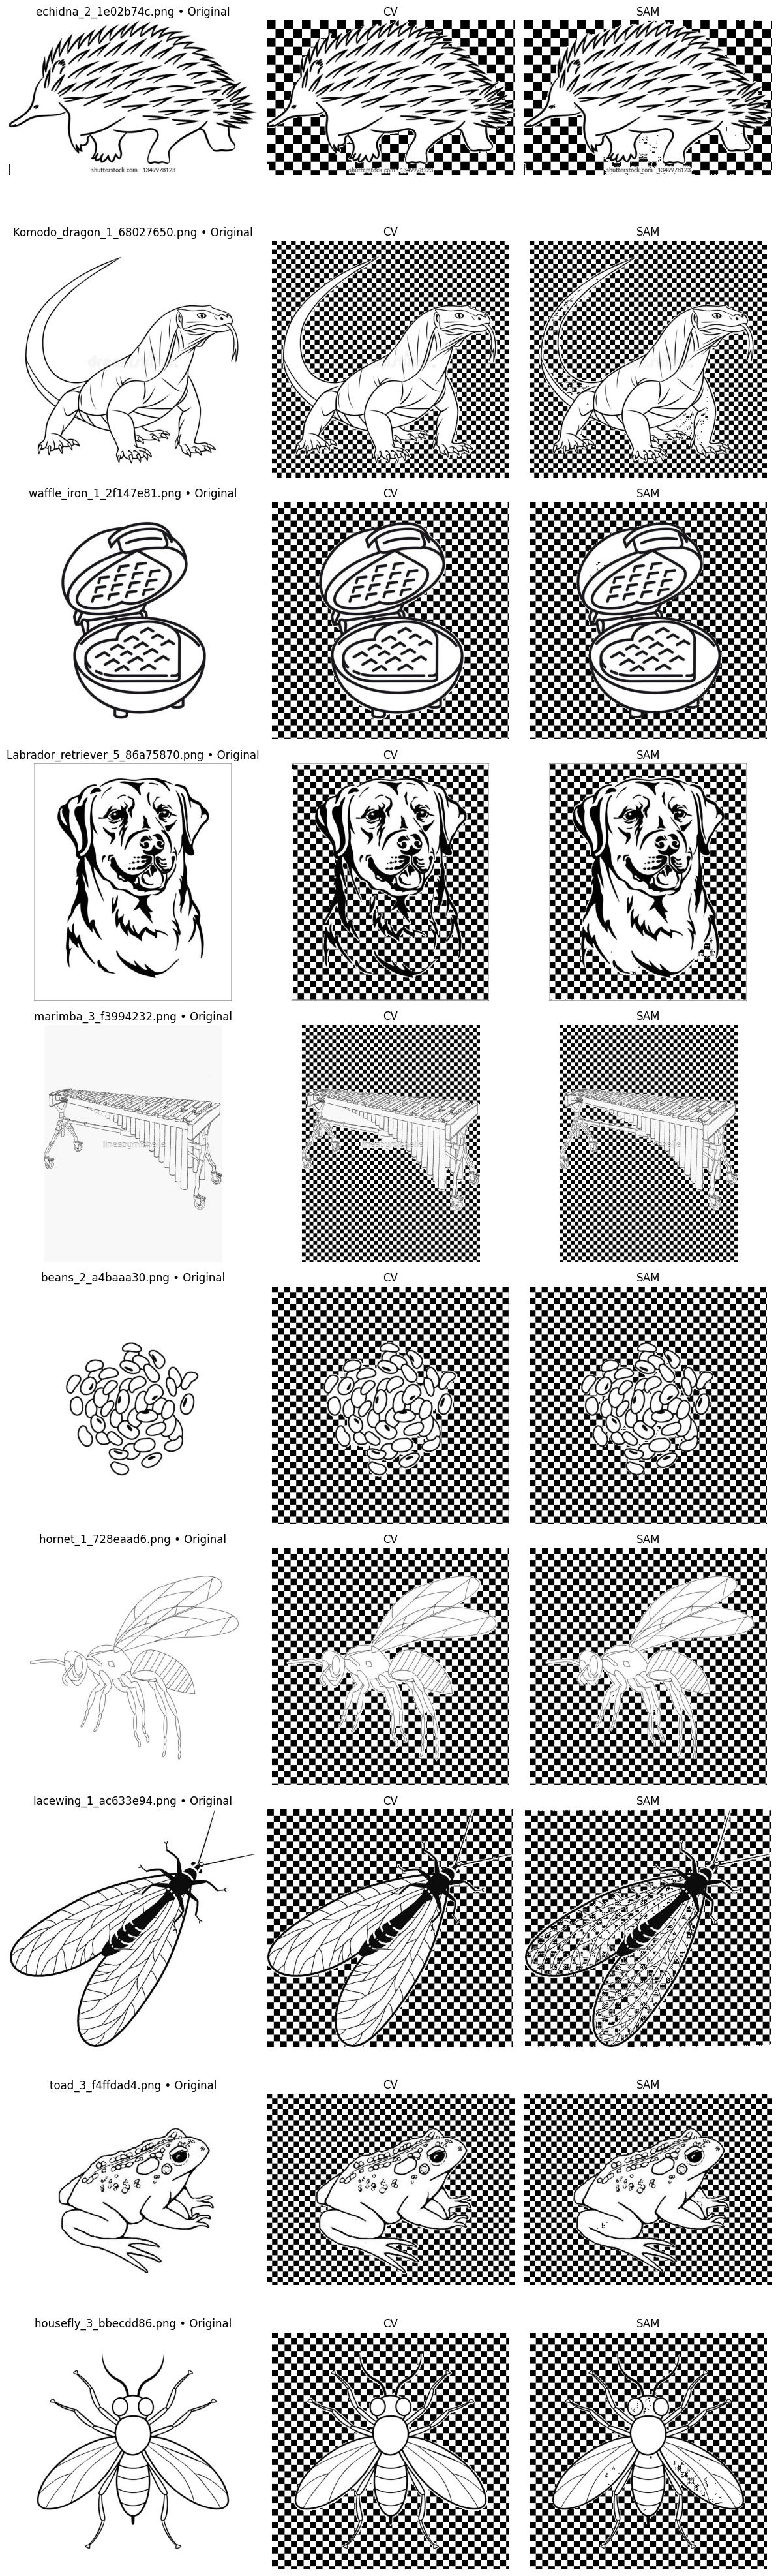

In [17]:
show_gallery(df, k=10)


## Recolor images pixel by pixel

In [18]:
df

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['red'],yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
1,"['black', 'white', 'brown']",pink,Newfoundland,https://fydn.imgix.net/m%2Fgen%2Fart-print-std...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
2,"['white', 'brown']",yellow,hare,https://t3.ftcdn.net/jpg/09/64/55/74/360_F_964...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",47,False,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
...,...,...,...,...,...,...,...,...,...,...,...
384,"['green', 'brown']",purple,bottle,https://c8.alamy.com/comp/2N4GG52/vector-black...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
385,['yellow'],green,cab,https://illustoon.com/photo/4847.png,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
386,"['black', 'brown']",purple,buzzard,https://c8.alamy.com/comp/3BMJHY0/forest-anima...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...
387,['brown'],blue,French loaf,https://previews.123rf.com/images/rastudio/ras...,/content/drive/MyDrive/Masterarbeit/data/norm_...,"{'white_background': 'yes', 'style': 'illustra...",23,True,1,/content/drive/MyDrive/Masterarbeit/data/cv_ma...,/content/drive/MyDrive/Masterarbeit/data/sam_m...


In [14]:
rng = np.random.default_rng(123)  # deterministic random subsets

def recolor_subset(arr_rgb, idx_flat, k, current_color, target_color):
    """Recolor k random pixels from idx_flat (flat indices) in-place on arr_rgb."""
    if k <= 0 or len(idx_flat) == 0:
        return arr_rgb
    chosen = rng.choice(idx_flat, size=min(k, len(idx_flat)), replace=False)
    flat = arr_rgb.reshape(-1, 3)
    for i in chosen:
        r, g, b = flat[i]
        flat[i] = color_remap((int(r), int(g), int(b)), current_color, target_color)
    return arr_rgb

def generate_variants(row, target_color, current_color="white"):
    """
    For one image + one target_color → save 21 variants:
      - FG series: 0..100% (11 images)
      - BG series: 10..100% (10 images)
    """
    # Load image and mask
    img = Image.open(row["image_path"]).convert("RGB")
    W, H = img.size
    m = Image.open(row["cv_mask_path"]).convert("L").resize((W, H), Image.NEAREST)
    mask = (np.array(m, dtype=np.uint8) > 127)  # True = FG

    stem = Path(row["image_path"]).stem
    color_dir = OUT_DIR / f"{stem}_{target_color}"
    color_dir.mkdir(parents=True, exist_ok=True)
    base = np.array(img, dtype=np.uint8)

    # flat indices for FG/BG
    idx_all = np.arange(H * W)
    idx_fg = idx_all[mask.flatten()]
    idx_bg = idx_all[~mask.flatten()]

    # ---- Foreground series (0..100%) ----
    fg_paths = []
    for pct in range(0, 101, 10):
        arr = base.copy()
        k = int(round(pct / 100.0 * len(idx_fg)))
        recolor_subset(arr, idx_fg, k, current_color, target_color)
        out_path = color_dir / f"FG_{pct:03d}.png"
        Image.fromarray(arr, "RGB").save(out_path)
        fg_paths.append(out_path)

    # ---- Background series (10..100%) on top of 100%-FG image ----
    bg_paths = []
    for pct in range(10, 101, 10):
        arr = base.copy()
        k = int(round(pct / 100.0 * len(idx_bg)))
        recolor_subset(arr, idx_bg, k, current_color, target_color)
        out_path = color_dir / f"BG_{pct:03d}.png"
        Image.fromarray(arr, "RGB").save(out_path)
        bg_paths.append(out_path)

    # keep return type as strings if your callers expect str paths
    return [str(p) for p in (fg_paths + bg_paths)]  # 21 paths

def normalize_colors(c):
    """Return a list of color strings from string or list-like entries."""
    if c is None:
        return []
    if isinstance(c, str):
        return [c.strip().lower()]
    try:
        return [str(x).strip().lower() for x in c if str(x).strip()]
    except Exception:
        return [str(c).strip().lower()]


In [57]:
def _variant_sort_key(p: Path):
    name = p.name
    m_fg = re.match(r"FG_(\d{3})\.png$", name)
    if m_fg:
        return (0, int(m_fg.group(1)))
    m_bg = re.match(r"BG_(\d{3})\.png$", name)
    if m_bg:
        return (1, int(m_bg.group(1)))
    return (9, name)

def collect_variants_for(image_path: str, target_color: str, out_root: Path = OUT_DIR):
    stem = Path(image_path).stem
    color_dir = out_root / f"{stem}_{target_color}"   # <-- the directory that exists

    # If the dir might not exist, you can early-return:
    if not color_dir.exists():
        return []

    fg = list(color_dir.glob("FG_*.png"))
    bg = list(color_dir.glob("BG_*.png"))

    paths = fg + bg
    return sorted(paths, key=_variant_sort_key)

def show_variants_grid(image_path: str, target_color: str, out_root: Path = OUT_DIR, thumb_w: int = 256):
    """
    Display a 2-row grid:
      Row 1: FG 0..100% (11 images)
      Row 2: BG 10..100% (10 images), shifted right by 1 so both rows end in the same column.
    """
    paths = collect_variants_for(image_path, target_color, out_root)
    if not paths:
        print(f"No variants found for {image_path}")
        return

    # Split into 11 + 10 (by filename pattern)
    fg_paths = [p for p in paths if "FG_" in p.name]   # 11
    bg_paths = [p for p in paths if "BG_" in p.name]   # 10

    cols = len(fg_paths)
    rows = 2
    fig_w = cols * (thumb_w / 100)  # ~100 px ≈ 1 inch
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, rows * 2.8))

    # Normalize axes to 2 x cols
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[axes[0]], [axes[1]]]

    def _draw_row(ax_row, paths_row, title_prefix, start_col=0):
      for c in range(cols):
          ax = ax_row[c]
          ax.axis("off")
          idx = c - start_col
          if 0 <= idx < len(paths_row):
              p = paths_row[idx]
              im = Image.open(p).convert("RGB")
              ax.imshow(im)
              m = re.search(r"(\d{3})(?=\.png$)", p.name)
              pct = int(m.group(1)) if m else ""
              ax.set_title(f"{title_prefix} {pct}%", fontsize=9)

    _draw_row(axes[0], fg_paths, "FG", start_col=0)  # 11 images
    _draw_row(axes[1], bg_paths, "BG", start_col=1)  # shift BG right by 1 (first slot empty)

    fig.suptitle(f"{Path(image_path).name} — {target_color}", fontsize=12)
    plt.tight_layout()
    plt.show()

Images:   0%|          | 0/1 [00:00<?, ?it/s]

Colors:   0%|          | 0/2 [00:00<?, ?it/s]

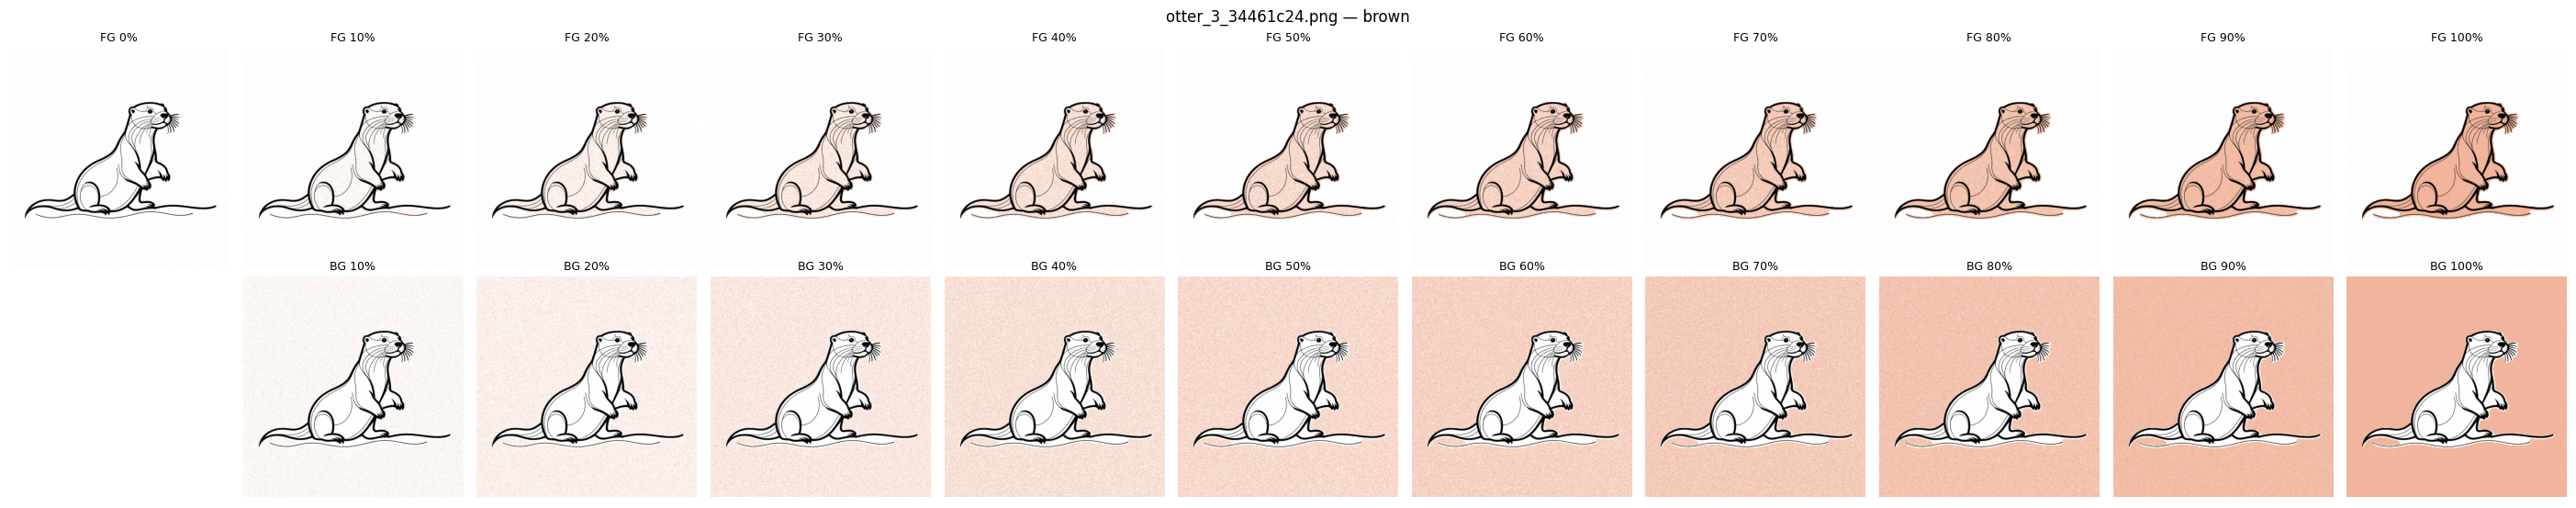

No variants found for /content/drive/MyDrive/Masterarbeit/data/norm_outline_images/otter_3_34461c24.png


In [58]:
# ---- Run over some rows (example: 10 random rows) ----
# Adjust fg_current_color/bg_current_color if your base is not white.
rows = df.sample(1, random_state=0).to_dict("records")
for row in tqdm(rows, desc="Images", position=0):
    targets = normalize_colors(ast.literal_eval(row["correct_answer"]))
    for tcol in tqdm(targets, desc="Colors", position=1, leave=False):
        #_ = generate_variants(row, target_color=tcol, current_color="white")
        show_variants_grid(row["image_path"], tcol)

In [42]:
%ls /content/drive/MyDrive/Masterarbeit/data/segmented_images/otter_3_34461c24_brown

BG_010.png  BG_050.png  BG_090.png  FG_020.png  FG_060.png  FG_100.png
BG_020.png  BG_060.png  BG_100.png  FG_030.png  FG_070.png
BG_030.png  BG_070.png  FG_000.png  FG_040.png  FG_080.png
BG_040.png  BG_080.png  FG_010.png  FG_050.png  FG_090.png
